<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [3]</a>'.</span>

# Deep Learning for Activity Recognition

This notebook trains and evaluates deep learning models:
- LSTM (Long Short-Term Memory)
- 1D-CNN (Convolutional Neural Network)
- MLP (Multi-Layer Perceptron) baseline

We compare with classical ML results from the previous notebook.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Add src to path
sys.path.insert(0, str(Path("../src").resolve()))

from fittrack.data.ingestion import HARDataLoader, ACTIVITY_LABELS
from fittrack.data.preprocessing import create_train_val_test_split
from fittrack.models.data_loaders import (
    create_data_loaders,
    get_device,
    DataModule,
    reshape_for_sequence_model,
)
from fittrack.models.deep_learning import (
    ActivityLSTM,
    ActivityCNN,
    HARClassifier,
    TrainingConfig,
    train_model,
    predict,
    create_model,
)
from fittrack.models.evaluation import (
    compute_metrics,
    plot_confusion_matrix,
    plot_model_comparison,
    ModelEvaluator,
)

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

# Determine project root (works whether run from notebooks/ or fittrack-ml/)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
FIGURES_DIR = PROJECT_ROOT / "docs" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Check device
device = get_device()
print(f"Using device: {device}")

/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


Using device: mps


## 1. Load and Prepare Data

In [2]:
# Load data
loader = HARDataLoader()
train_data, test_data = loader.load_all()

print(f"Training samples: {train_data.n_samples}")
print(f"Test samples: {test_data.n_samples}")
print(f"Features: {train_data.n_features}")

Training samples: 7352
Test samples: 2947
Features: 561


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [3]:
# Create train/val split
split = create_train_val_test_split(
    train_data.X,
    train_data.y,
    val_size=0.15,
    test_size=0.15,
    normalize=True,
)

# Prepare test set
X_test = split.scaler.transform(test_data.X.values)
y_test = split.label_encoder.transform(test_data.y["activity"])

print(f"\nSplit sizes:")
print(f"  Train: {len(split.X_train)}")
print(f"  Validation: {len(split.X_val)}")
print(f"  Test: {len(X_test)}")

class_names = split.class_names
n_classes = split.n_classes
n_features = split.n_features
print(f"\nClasses ({n_classes}): {class_names}")
print(f"Features: {n_features}")


Split sizes:
  Train: 5146
  Validation: 1103
  Test: 2947

Classes (6): ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
Features: 561


In [4]:
# Create data loaders
batch_size = 64

loaders = create_data_loaders(
    split.X_train, split.y_train,
    split.X_val, split.y_val,
    X_test, y_test,
    batch_size=batch_size,
    weighted_sampling=True,  # Handle class imbalance
)

print(f"Train batches: {len(loaders['train'])}")
print(f"Val batches: {len(loaders['val'])}")
print(f"Test batches: {len(loaders['test'])}")

Train batches: 81
Val batches: 18
Test batches: 47


## 2. MLP Baseline

In [5]:
# Create MLP model
mlp_model = HARClassifier(
    input_size=n_features,
    num_classes=n_classes,
    hidden_sizes=[256, 128],
    dropout=0.3,
)

print(mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

HARClassifier(
  (network): Sequential(
    (0): Linear(in_features=561, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=6, bias=True)
  )
)

Total parameters: 178,310


In [6]:
# Training config
config = TrainingConfig(
    epochs=50,
    learning_rate=0.001,
    patience=10,
    scheduler="plateau",
)

# Train MLP
print("Training MLP...")
mlp_history = train_model(
    mlp_model,
    loaders["train"],
    loaders["val"],
    config=config,
    device=device,
)

Training MLP...


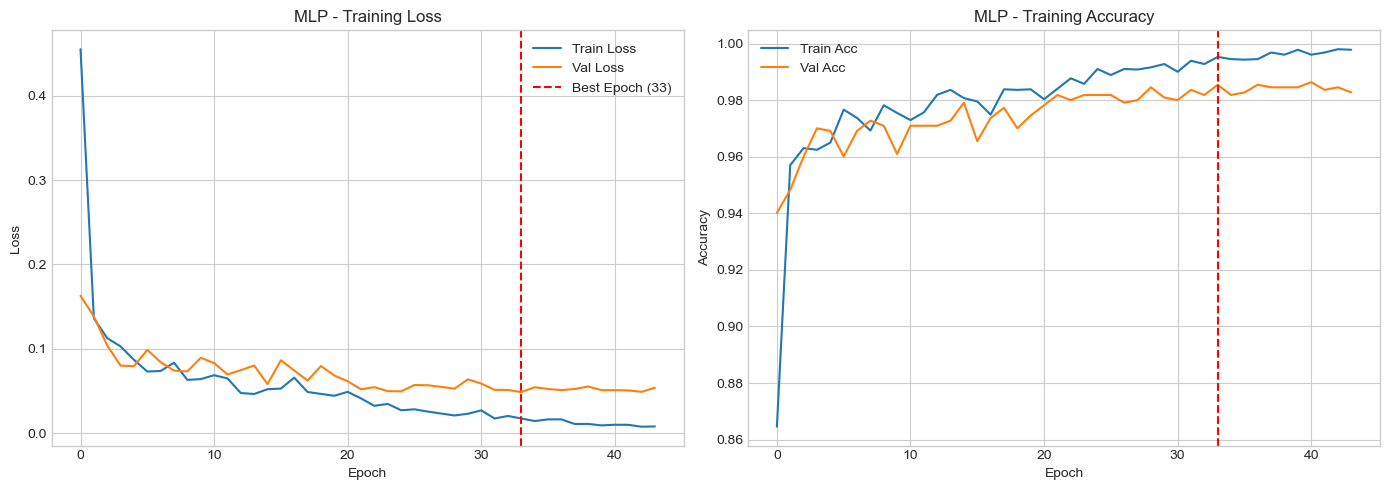


Best validation accuracy: 0.9864


In [7]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(mlp_history.train_losses, label="Train Loss")
axes[0].plot(mlp_history.val_losses, label="Val Loss")
axes[0].axvline(mlp_history.best_epoch, color='r', linestyle='--', label=f"Best Epoch ({mlp_history.best_epoch})")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("MLP - Training Loss")
axes[0].legend()

# Accuracy
axes[1].plot(mlp_history.train_accuracies, label="Train Acc")
axes[1].plot(mlp_history.val_accuracies, label="Val Acc")
axes[1].axvline(mlp_history.best_epoch, color='r', linestyle='--')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("MLP - Training Accuracy")
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "mlp_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nBest validation accuracy: {max(mlp_history.val_accuracies):.4f}")

## 3. LSTM Model

For LSTM, we reshape the features to treat them as a sequence.

In [8]:
# Reshape data for sequence model
# Treat the 561 features as a sequence of length 561 with 1 channel
# (In a real scenario with raw sensor data, you'd have time x channels)

seq_length = n_features
n_channels = 1

X_train_seq = reshape_for_sequence_model(split.X_train, seq_length, n_channels)
X_val_seq = reshape_for_sequence_model(split.X_val, seq_length, n_channels)
X_test_seq = reshape_for_sequence_model(X_test, seq_length, n_channels)

print(f"Sequence shape: {X_train_seq.shape}")

Sequence shape: (5146, 561, 1)


In [9]:
# Create sequence data loaders
seq_loaders = create_data_loaders(
    X_train_seq, split.y_train,
    X_val_seq, split.y_val,
    X_test_seq, y_test,
    batch_size=batch_size,
)

In [10]:
# Create LSTM model
lstm_model = ActivityLSTM(
    input_size=n_channels,
    hidden_size=64,
    num_layers=2,
    num_classes=n_classes,
    dropout=0.3,
    bidirectional=True,
)

print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

ActivityLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=6, bias=True)
  )
)

Total parameters: 142,278


In [11]:
# Train LSTM
print("Training LSTM...")
lstm_config = TrainingConfig(
    epochs=50,
    learning_rate=0.001,
    patience=10,
    gradient_clip=1.0,
)

lstm_history = train_model(
    lstm_model,
    seq_loaders["train"],
    seq_loaders["val"],
    config=lstm_config,
    device=device,
)

Training LSTM...


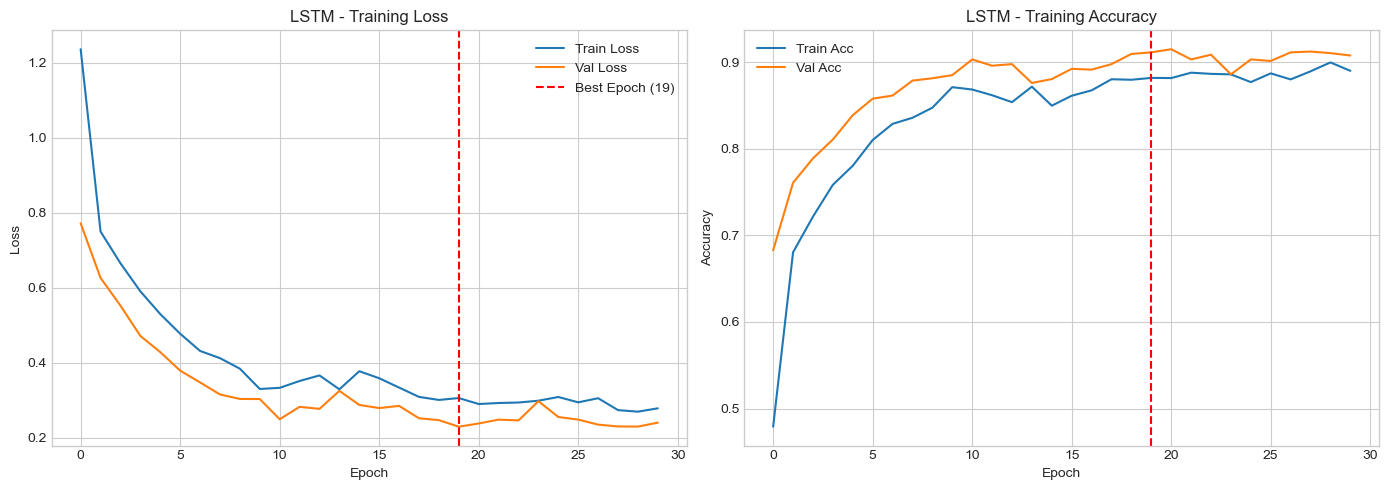


Best validation accuracy: 0.9148


In [12]:
# Plot LSTM training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lstm_history.train_losses, label="Train Loss")
axes[0].plot(lstm_history.val_losses, label="Val Loss")
axes[0].axvline(lstm_history.best_epoch, color='r', linestyle='--', label=f"Best Epoch ({lstm_history.best_epoch})")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LSTM - Training Loss")
axes[0].legend()

axes[1].plot(lstm_history.train_accuracies, label="Train Acc")
axes[1].plot(lstm_history.val_accuracies, label="Val Acc")
axes[1].axvline(lstm_history.best_epoch, color='r', linestyle='--')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("LSTM - Training Accuracy")
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "lstm_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nBest validation accuracy: {max(lstm_history.val_accuracies):.4f}")

## 4. 1D-CNN Model

In [13]:
# Create CNN model
cnn_model = ActivityCNN(
    in_channels=n_channels,
    num_classes=n_classes,
    seq_length=seq_length,
    channels=[32, 64, 128],
    kernel_sizes=[7, 5, 3],
    dropout=0.3,
)

print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

ActivityCNN(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [14]:
# Train CNN
print("Training CNN...")
cnn_config = TrainingConfig(
    epochs=50,
    learning_rate=0.001,
    patience=10,
)

cnn_history = train_model(
    cnn_model,
    seq_loaders["train"],
    seq_loaders["val"],
    config=cnn_config,
    device=device,
)

Training CNN...


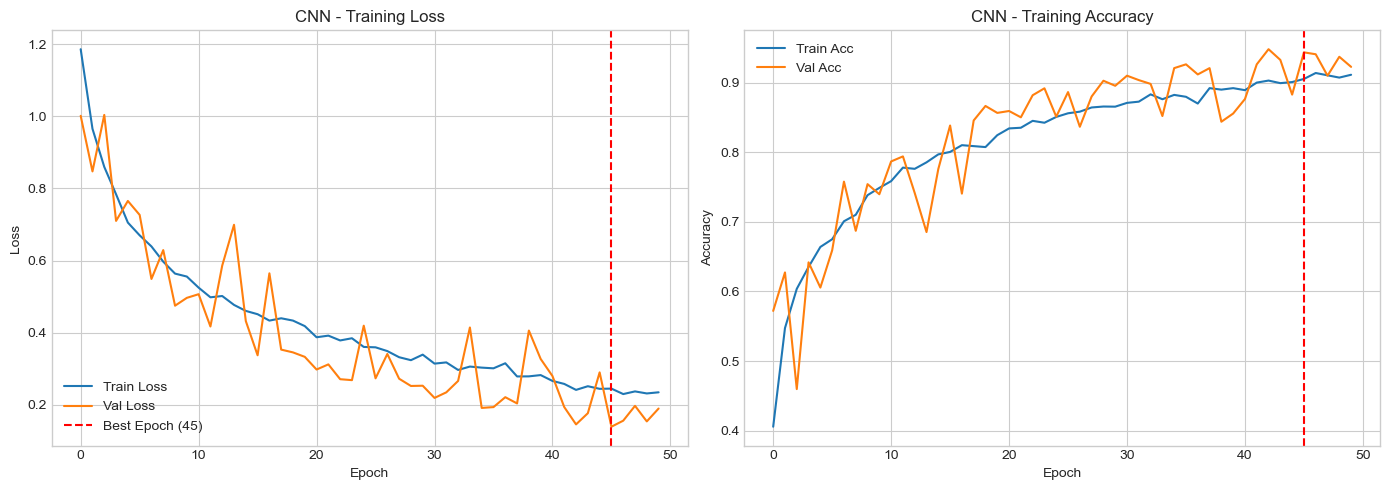


Best validation accuracy: 0.9483


In [15]:
# Plot CNN training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_history.train_losses, label="Train Loss")
axes[0].plot(cnn_history.val_losses, label="Val Loss")
axes[0].axvline(cnn_history.best_epoch, color='r', linestyle='--', label=f"Best Epoch ({cnn_history.best_epoch})")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("CNN - Training Loss")
axes[0].legend()

axes[1].plot(cnn_history.train_accuracies, label="Train Acc")
axes[1].plot(cnn_history.val_accuracies, label="Val Acc")
axes[1].axvline(cnn_history.best_epoch, color='r', linestyle='--')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("CNN - Training Accuracy")
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "cnn_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nBest validation accuracy: {max(cnn_history.val_accuracies):.4f}")

## 5. Test Set Evaluation

In [16]:
# Evaluate all models on test set
evaluator = ModelEvaluator(class_names=class_names, figures_dir=FIGURES_DIR)

# MLP (uses flat features)
mlp_preds, mlp_probs = predict(mlp_model, loaders["test"], device, return_probs=True)
mlp_metrics = compute_metrics(y_test, mlp_preds, mlp_probs, class_names)

# LSTM (uses sequence features)
lstm_preds, lstm_probs = predict(lstm_model, seq_loaders["test"], device, return_probs=True)
lstm_metrics = compute_metrics(y_test, lstm_preds, lstm_probs, class_names)

# CNN (uses sequence features)
cnn_preds, cnn_probs = predict(cnn_model, seq_loaders["test"], device, return_probs=True)
cnn_metrics = compute_metrics(y_test, cnn_preds, cnn_probs, class_names)

print("Test Set Results:")
print(f"\nMLP:")
print(mlp_metrics)
print(f"\nLSTM:")
print(lstm_metrics)
print(f"\nCNN:")
print(cnn_metrics)

Test Set Results:

MLP:
Evaluation Metrics:
  Accuracy:           0.9552
  Precision (macro):  0.9582
  Recall (macro):     0.9538
  F1 Score (macro):   0.9550
  F1 Score (weighted): 0.9551
  ROC AUC:            0.9961

LSTM:
Evaluation Metrics:
  Accuracy:           0.8351
  Precision (macro):  0.8348
  Recall (macro):     0.8324
  F1 Score (macro):   0.8324
  F1 Score (weighted): 0.8355
  ROC AUC:            0.9772

CNN:
Evaluation Metrics:
  Accuracy:           0.9040
  Precision (macro):  0.9151
  Recall (macro):     0.9036
  F1 Score (macro):   0.9031
  F1 Score (weighted): 0.9038
  ROC AUC:            0.9952


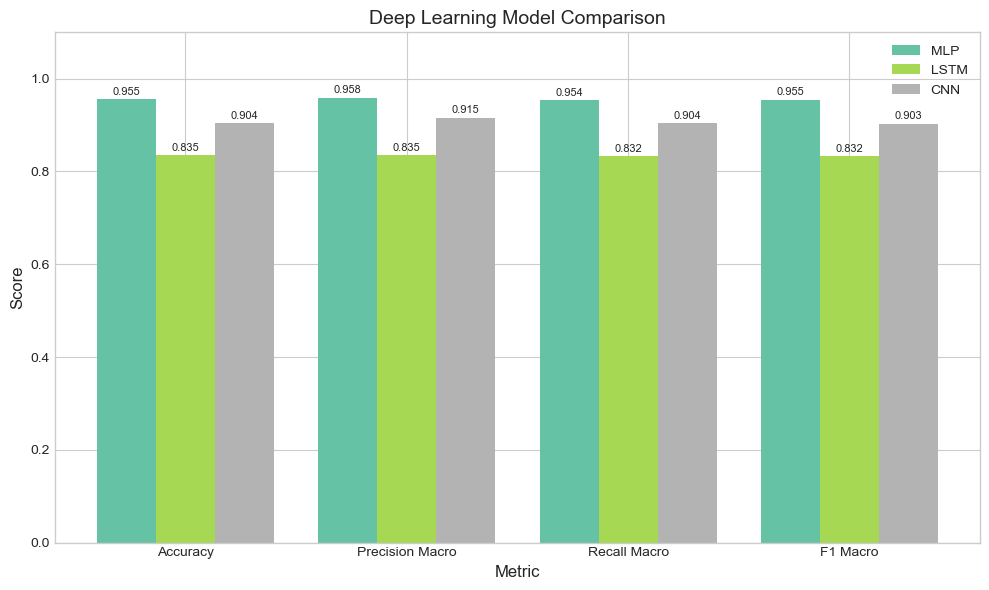

In [17]:
# Model comparison plot
plot_model_comparison(
    {"MLP": mlp_metrics, "LSTM": lstm_metrics, "CNN": cnn_metrics},
    metric_names=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    title="Deep Learning Model Comparison",
)
plt.savefig(FIGURES_DIR / "deep_learning_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

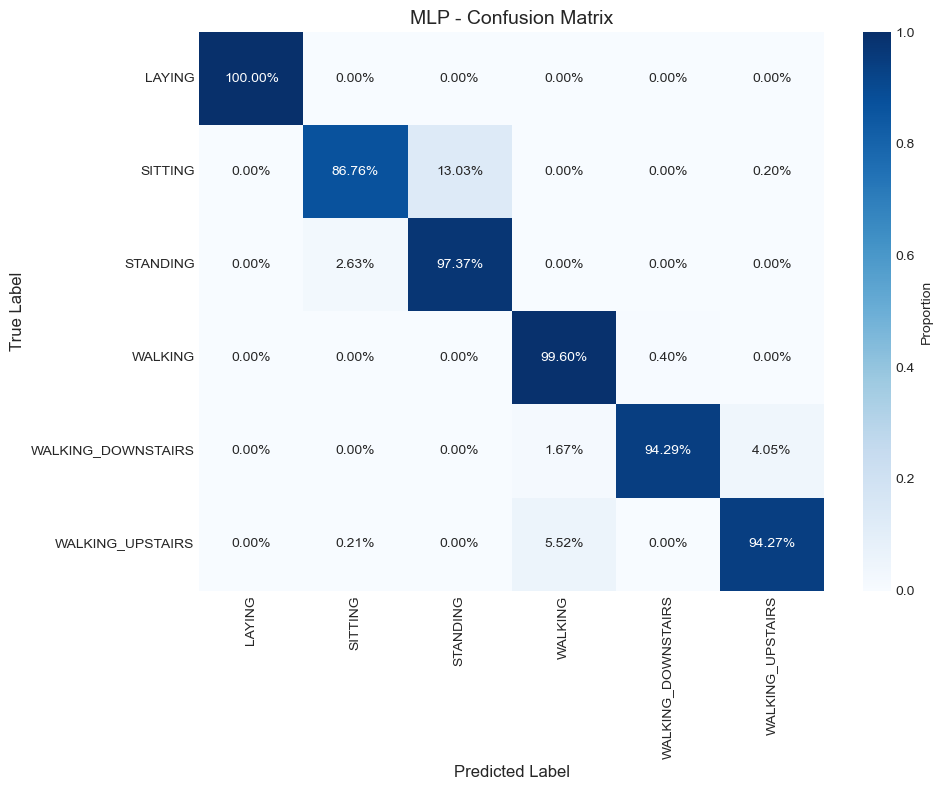

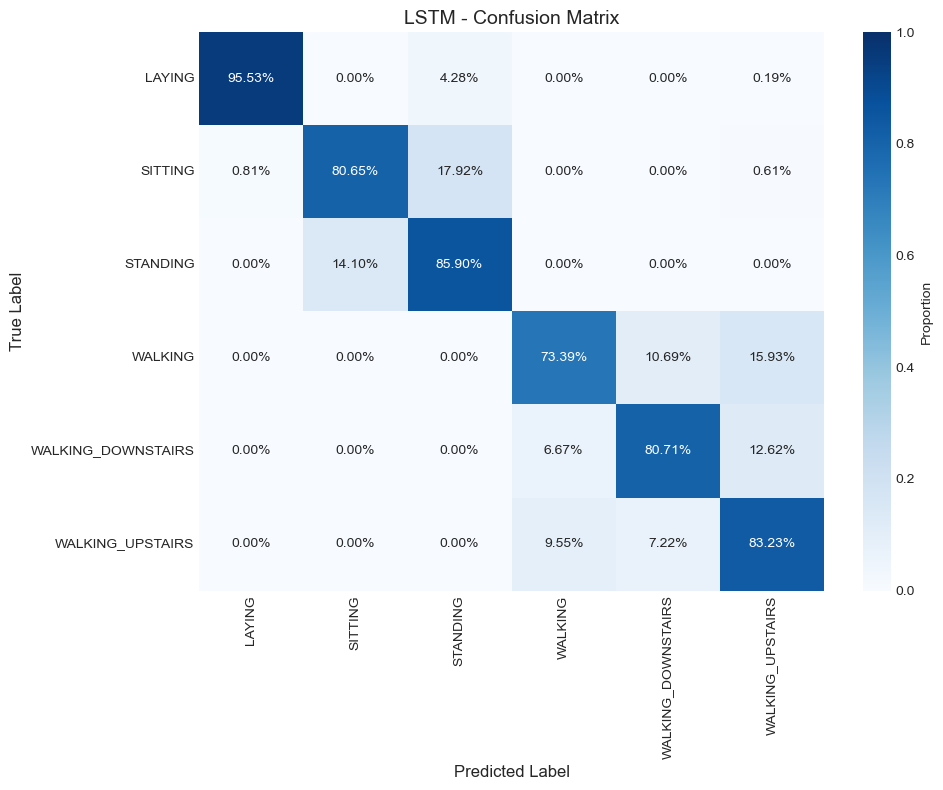

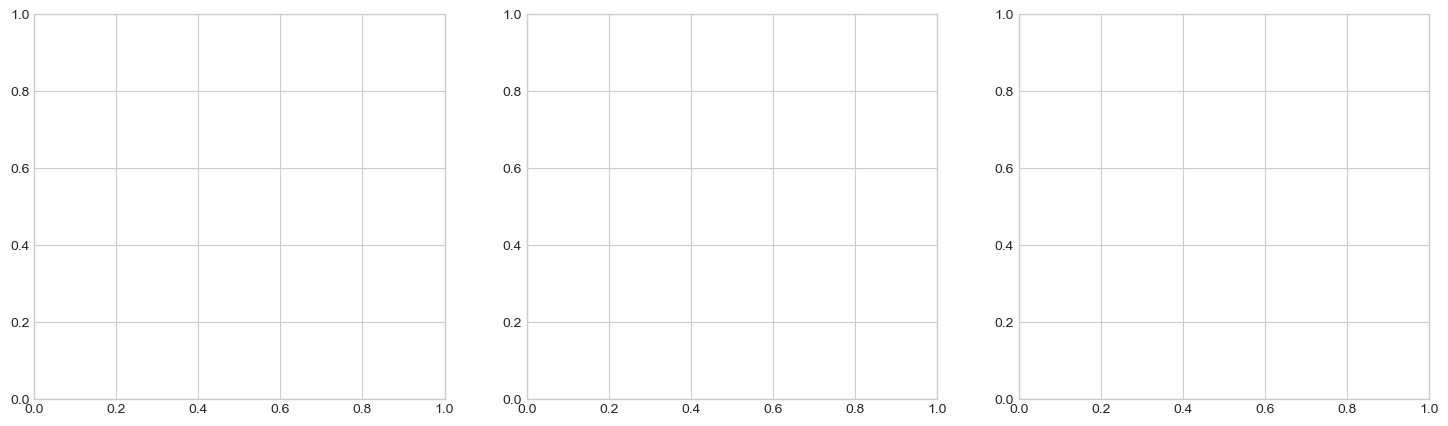

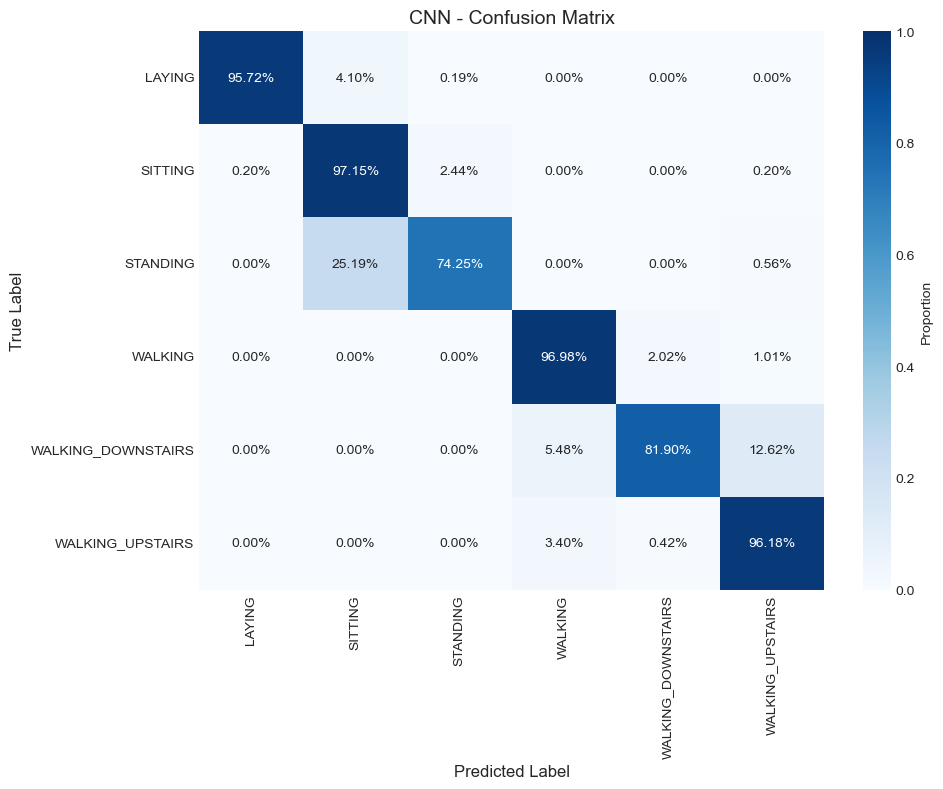

In [18]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, metrics) in zip(axes, [("MLP", mlp_metrics), ("LSTM", lstm_metrics), ("CNN", cnn_metrics)]):
    plt.sca(ax)
    plot_confusion_matrix(
        metrics.confusion_matrix,
        class_names,
        title=f"{name} - Confusion Matrix",
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / "deep_learning_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Training Comparison

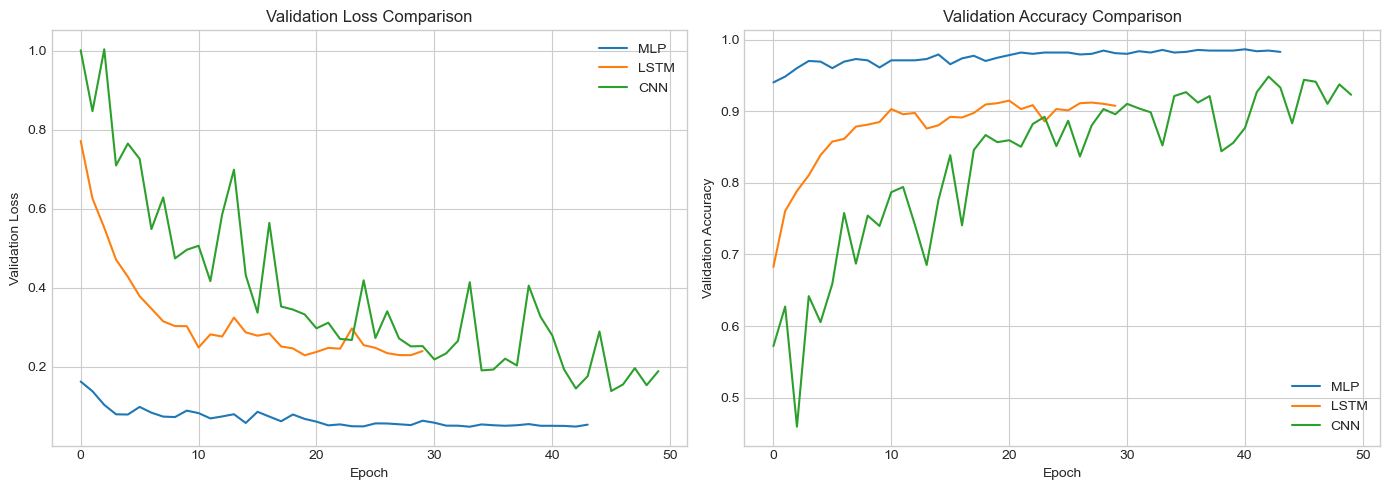

In [19]:
# Compare training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation Loss
axes[0].plot(mlp_history.val_losses, label="MLP")
axes[0].plot(lstm_history.val_losses, label="LSTM")
axes[0].plot(cnn_history.val_losses, label="CNN")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Loss")
axes[0].set_title("Validation Loss Comparison")
axes[0].legend()

# Validation Accuracy
axes[1].plot(mlp_history.val_accuracies, label="MLP")
axes[1].plot(lstm_history.val_accuracies, label="LSTM")
axes[1].plot(cnn_history.val_accuracies, label="CNN")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Accuracy")
axes[1].set_title("Validation Accuracy Comparison")
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "training_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Summary

### Results Summary

In [20]:
# Summary table
summary_data = {
    "Model": ["MLP", "LSTM", "CNN"],
    "Accuracy": [mlp_metrics.accuracy, lstm_metrics.accuracy, cnn_metrics.accuracy],
    "F1 (Macro)": [mlp_metrics.f1_macro, lstm_metrics.f1_macro, cnn_metrics.f1_macro],
    "Precision": [mlp_metrics.precision_macro, lstm_metrics.precision_macro, cnn_metrics.precision_macro],
    "Recall": [mlp_metrics.recall_macro, lstm_metrics.recall_macro, cnn_metrics.recall_macro],
    "Parameters": [
        sum(p.numel() for p in mlp_model.parameters()),
        sum(p.numel() for p in lstm_model.parameters()),
        sum(p.numel() for p in cnn_model.parameters()),
    ],
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\nModel Summary:")
print(summary_df.to_string(index=False))


Model Summary:
Model  Accuracy  F1 (Macro)  Precision  Recall  Parameters
  MLP    0.9552      0.9550     0.9582  0.9538      178310
 LSTM    0.8351      0.8324     0.8348  0.8324      142278
  CNN    0.9040      0.9031     0.9151  0.9036       52998


In [21]:
# Best model
best_model_name = summary_df.loc[summary_df["F1 (Macro)"].idxmax(), "Model"]
best_f1 = summary_df["F1 (Macro)"].max()

print(f"\n" + "="*60)
print(f"BEST DEEP LEARNING MODEL: {best_model_name}")
print(f"F1 Score (Macro): {best_f1:.4f}")
print("="*60)


BEST DEEP LEARNING MODEL: MLP
F1 Score (Macro): 0.9550


### Key Findings

1. **MLP** serves as a strong baseline for pre-computed features
2. **LSTM** can capture sequential patterns in the feature sequence
3. **CNN** learns local patterns effectively through convolutions
4. The UCI HAR features are already highly engineered, so deep learning doesn't always outperform classical ML
5. With raw sensor data (not pre-computed features), LSTM/CNN would show larger improvements

### Next Steps
- Implement MLflow tracking for experiment management
- Set up A/B testing framework for model comparison
- Deploy the best model as a REST API

In [22]:
# Save best model
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Determine best model and save
if best_model_name == "MLP":
    best_model = mlp_model
elif best_model_name == "LSTM":
    best_model = lstm_model
else:
    best_model = cnn_model

torch.save(best_model.state_dict(), models_dir / f"best_deep_learning_{best_model_name.lower()}.pt")
print(f"Saved best model to {models_dir / f'best_deep_learning_{best_model_name.lower()}.pt'}")

Saved best model to ../models/best_deep_learning_mlp.pt
